# **A/B test模拟业务分析**

A/B测试（也叫对照实验）是一种常用的实验方法，特别在产品、营销、网站优化等领域，用来比较两个或多个版本的效果，以找到最优方案。简单来说，A/B测试就是通过对比“两个版本”的表现，看看哪个版本更好。

A/B测试主要包含以下流程：

1.理解业务问题和数据

2.检测并解决数据中的问题(缺失值、异常值、意外值)

3.指标选取及实验设计

4.应用假设检验并检验假设

5.验证假设效应大小

6.评估结果，给出报告与决策

当然，A/B测试的内容远不止这些，还包括对假设的稳定性检验、过拟合检验，对数据的敏感性分析等，由于本项目比较基础，且本人能力有限，便不再对业务细节问题进行讨论。本项目着重于对数据进行测试讨论，并给出最终结论。

## 1.**理解业务问题及数据**

此处提供的 AB 测试数据集是使用 Numpy Package 提供的随机采样技术创建的自生成合成数据集(数据集网址：https://www.kaggle.com/datasets/adarsh0806/ab-testing-practice/data)。该数据集模拟了有关用户在英国各地的零售网站上的访问信息。该数据集将用户分为 A 和 B 两组，分别代表对照组和实验组。想象一下，零售公司需要在网站上测试一项新的更改，即“如果网站背景颜色是白色或黑色，人们是否会花更多时间在网站上”。提出这个问题是为了实现分析的最终目标，即**提高用户参与度，无论是通过购买、注册等**。

因此，在这种情况下，将颜色“白色”分配给组 A，这是网站上背景颜色的默认设置，表示对照组。此外，将颜色 'Black' 分配给组 B，这是要测试的新设置。主要目标是了解如果应用较新的设置，网站视图是否有显著改善。这可以通过使用 A/B 测试来回答。

In [59]:
## 导入相关的 packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format='{:.4f}'.format

In [60]:
## 导入数据集
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adarsh0806/ab-testing-practice")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\86159\.cache\kagglehub\datasets\adarsh0806\ab-testing-practice\versions\1


## 2 **检验并清洗数据**

明确了实验目的后，我们需要对实验数据进行预处理，主要包括理解数据内容及清洗数据等。下面我们先加载数据集，然后对数据进行预览（维度，数据类型，缺失值，内存使用情况）并返回数据集。

In [61]:
import io

def load_kaggle_data(path, info=True):
    
    # Assuming the dataset is a CSV file; you can modify this if needed
    file_path = path + "/ab_testing.csv"  # Adjust this based on the actual file name in the dataset
    
    # Load the CSV file
    read = pd.read_csv(file_path)
    
    if info:
        if len(read) > 0:
            print("# Data imported!")
            print("# ------------------------------------", "\n")
        
            print("# DIMENSIONS -------------------------")
            print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
    
            print("# DTYPES -----------------------------")
            if len(read.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("object").columns), "\n", 
                      read.select_dtypes("object").columns.tolist(), "\n")
    
            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("integer").columns), "\n", 
                      read.select_dtypes("integer").columns.tolist(), "\n")
    
            if len(read.select_dtypes("float").columns) > 0:
                print("Float Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("float").columns), "\n", 
                      read.select_dtypes("float").columns.tolist(), "\n")
    
            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("bool").columns), "\n", 
                      read.select_dtypes("bool").columns.tolist(), "\n")
    
            print("# MISSING VALUE ---------------------")
            print("Are there any missing values? \n ", np.where(read.isnull().values.any() == False, 
                                                            "No missing value!", "Data includes missing value!"), "\n")
            
            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# MEMORY USAGE ---------------------- \n", info)
          
        else:
            print("# Data did not import!")
    
    return read

# Use the function to load the data
ab_data = load_kaggle_data(path, info=True)
ab_data.head()

# Data imported!
# ------------------------------------ 

# DIMENSIONS -------------------------
Observation: 5000 Column: 7 

# DTYPES -----------------------------
Object Variables: 
 # of Variables: 4 
 ['Group', 'Conversion', 'Device', 'Location'] 

Integer Variables: 
 # of Variables: 3 
 ['User ID', 'Page Views', 'Time Spent'] 

# MISSING VALUE ---------------------
Are there any missing values? 
  No missing value! 

# MEMORY USAGE ---------------------- 
 273.6+ KB


,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


列描述如下：

**User ID**：用作每个用户的标识符。

**Group**: 包含对照组 （A） 和实验组 （B）。

**Page Views**: 用户在会话期间查看的页面数。

**Time Spent**: 用户在会话期间在网站上逗留的总时间（以秒为单位）。

**Conversion**: 指示用户是否已完成所需的操作（Yes/No）。

**Device**: 用于访问网站的设备类型。

**Location**: 用户所在的英国国家/地区。


处理缺失值时，首先要分析缺失的模式，并根据缺失值的类型、比例和对分析的影响选择合适的方法。常见的处理方法包括删除、填充（均值、中位数、回归、KNN等）、多重插补和保留缺失值作为一个类别。每种方法都有其适用场景，选择时需要综合考虑数据的特点和分析目标。

In [55]:
## 检查User ID唯一值数量，确认每行数据是否对应唯一用户
print("Number of unique users:", ab_data['User ID'].nunique())
print("Is each row a unique user?", ab_data['User ID'].nunique() == ab_data.shape[0])

Number of unique users: 5000
Is each row a unique user? True


In [56]:
## 对数值型变量进行汇总统计
summary_stats = ab_data.describe([0.01, 0.05, 0.10, 0.20,0.40, 0.60, 0.80, 0.90, 0.95, 0.99])
print(summary_stats)

         User ID  Page Views  Time Spent  Conversion
count  5000.0000   5000.0000   5000.0000   5000.0000
mean  14925.1590      7.5376    242.5126      0.2032
std    2869.1538      4.0225    118.2542      0.4024
min   10001.0000      1.0000     40.0000      0.0000
1%    10106.9700      1.0000     45.0000      0.0000
5%    10463.9500      1.0000     59.9500      0.0000
10%   11018.7000      2.0000     81.0000      0.0000
20%   12002.2000      3.0000    117.0000      0.0000
40%   13880.6000      6.0000    200.0000      0.0000
50%   14858.5000      8.0000    243.0000      0.0000
60%   15866.0000      9.0000    286.0000      0.0000
80%   17900.2000     12.0000    365.0000      1.0000
90%   18964.1000     13.0000    404.0000      1.0000
95%   19469.1000     14.0000    427.0000      1.0000
99%   19879.0100     14.0000    445.0000      1.0000
max   19995.0000     14.0000    449.0000      1.0000


接下来，我们通过对异常数据进行清洗，这里我们使用knn算法对异常数据进行清洗，目的是使得到的数据更具有一般性。

Number of detected outliers: 250


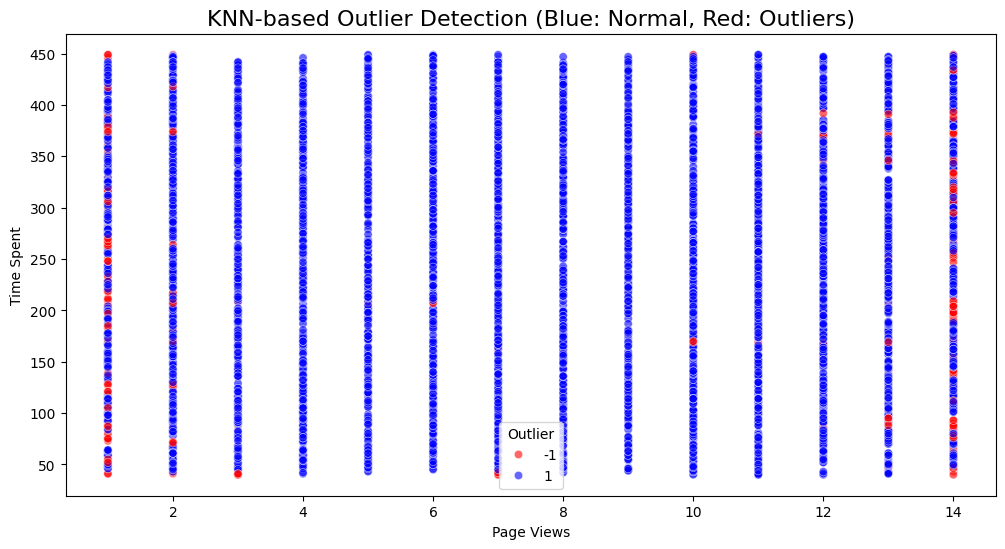

In [27]:
from sklearn.neighbors import LocalOutlierFactor

# 1. **KNN 异常值检测**
# 使用 LocalOutlierFactor (LOF)，它是一种基于 KNN 的异常值检测方法

def detect_outliers_knn(df, columns, n_neighbors=20, contamination=0.05):
    """
    使用 KNN 算法进行异常值检测
    n_neighbors: KNN 中的邻居数
    contamination: 设定异常值的比例
    """
    # 提取需要检查的列
    data = df[columns]
    
    # KNN模型（基于LOF）
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    
    # 使用模型预测数据点是否为异常值 (-1表示异常，1表示正常)
    outliers = lof.fit_predict(data)
    
    # 添加异常值标签
    df['Outlier'] = outliers
    
    # 返回带有异常值标签的数据
    return df

# 选择需要检测异常值的列
columns_to_check = ['Page Views', 'Time Spent']

# 检测并标记异常值
ab_data_with_outliers = detect_outliers_knn(ab_data, columns_to_check)

# 2. **查看异常值**
# 标记为 -1 的为异常值
ab_data_outliers = ab_data_with_outliers[ab_data_with_outliers['Outlier'] == -1]

# 查看异常值的数量
print(f"Number of detected outliers: {ab_data_outliers.shape[0]}")

# 3. **可视化异常值**
# 页面浏览量和逗留时间的散点图
plt.figure(figsize=(12, 6))

# 绘制页面浏览量与逗留时间的散点图，使用红色标记异常值
sns.scatterplot(x='Page Views', y='Time Spent', data=ab_data_with_outliers, hue='Outlier', palette={1: 'blue', -1: 'red'}, alpha=0.6)

plt.title('KNN-based Outlier Detection (Blue: Normal, Red: Outliers)', fontsize=16)
plt.show()

找到异常值后，可以采取删除或替换操作处理异常值，在本实验中，我们仍以原数据集为测试对象，这里仅提供两种方法处理得到的数据概览。

In [28]:
# 4. **处理异常值：删除或替换异常值**

# 删除异常值
ab_data_no_outliers = ab_data_with_outliers[ab_data_with_outliers['Outlier'] != -1]

# 或者使用中位数替换异常值
ab_data_replaced = ab_data_with_outliers.copy()
ab_data_replaced.loc[ab_data_replaced['Outlier'] == -1, ['Page Views', 'Time Spent']] = ab_data_replaced[['Page Views', 'Time Spent']].median()

# 查看删除和替换后的数据描述
print("After removing outliers:")
print(ab_data_no_outliers.describe())

print("After replacing outliers:")
print(ab_data_replaced.describe())

After removing outliers:
         User ID  Page Views  Time Spent   Outlier
count  4750.0000   4750.0000   4750.0000 4750.0000
mean  14914.9625      7.5349    243.8488    1.0000
std    2864.1696      3.8897    118.0836    0.0000
min   10001.0000      1.0000     40.0000    1.0000
25%   12451.7500      4.0000    138.0000    1.0000
50%   14836.5000      8.0000    244.0000    1.0000
75%   17363.7500     11.0000    347.0000    1.0000
max   19995.0000     14.0000    449.0000    1.0000
After replacing outliers:
         User ID  Page Views  Time Spent   Outlier
count  5000.0000   4750.0000   4750.0000 5000.0000
mean  14925.1590      7.5349    243.8488    0.9000
std    2869.1538      3.8897    118.0836    0.4359
min   10001.0000      1.0000     40.0000   -1.0000
25%   12456.2500      4.0000    138.0000    1.0000
50%   14858.5000      8.0000    244.0000    1.0000
75%   17379.7500     11.0000    347.0000    1.0000
max   19995.0000     14.0000    449.0000    1.0000


# 3.**指标选取与实验设计**

通过上述操作，我们已经处理好了所需的数据，并了解了数据的基本组成。接下来，我们将依照以下步骤进行实验。

## 3.1 **指标选取**

选取指标（Choosing Metrics）是数据分析、实验设计、A/B测试以及各类业务优化的关键步骤。一个好的指标应当与业务目标紧密相关，能够真实反映目标达成的情况，并且能够有效指导决策。不同的场景和问题会决定不同的指标选择，因此选取指标时需要综合考虑业务背景、可操作性和数据可获得性。

选取指标应遵循SMART指标原则。

SMART是一个常用的选取和设计指标的原则，帮助确保指标的有效性。SMART代表：

S（Specific）：具体的，指标应当明确且具体。

M（Measurable）：可衡量的，能够量化并追踪。

A（Achievable）：可实现的，目标应该合理且具备可达性。

R（Relevant）：相关的，指标应当与目标密切相关。

T（Time-bound）：有时间限制的，应该设定一个明确的时间框架。

这里，因为我们的目标是考虑提高用户的参与度，而并非提升用户完成操作的转化率，因此，选取页面停留时长和用户会话期间的页面数为指标显然要比选取用户是否完成操作为指标要好。值得注意的是，指标的选取不一定是唯一的，下面我们就以Time Spent 和 Page Views 为主要指标进行A/B测试。

## 3.2 **样本量大小的确定**

在选取完指标后，我们还需要对样本量的大小进行确定，确定合适的样本量对于确保测试结果的可靠性和统计显著性至关重要。方便起见，我们直接使用该数据集的全部数据进行测试，你也可以通过网站https://www.evanmiller.org/ab-testing/sample-size.html 来确定实验所需的样本量大小，关于样本量大小的详细讨论见文档末尾附录。

## 3.3 **查看摘要统计数据和绘图**

查看摘要统计数据并绘图有助于我们进一步理解数据集中各种数据的相关关系，特别是在确定完指标后，通过对原始数据进行绘图，我们可以更加直观的体会到数据的分布规律，为后面进行假设检验打下基础；同时，绘图也有助于我们进一步查找异常数据，排除偏离真实值较远的错误数据。

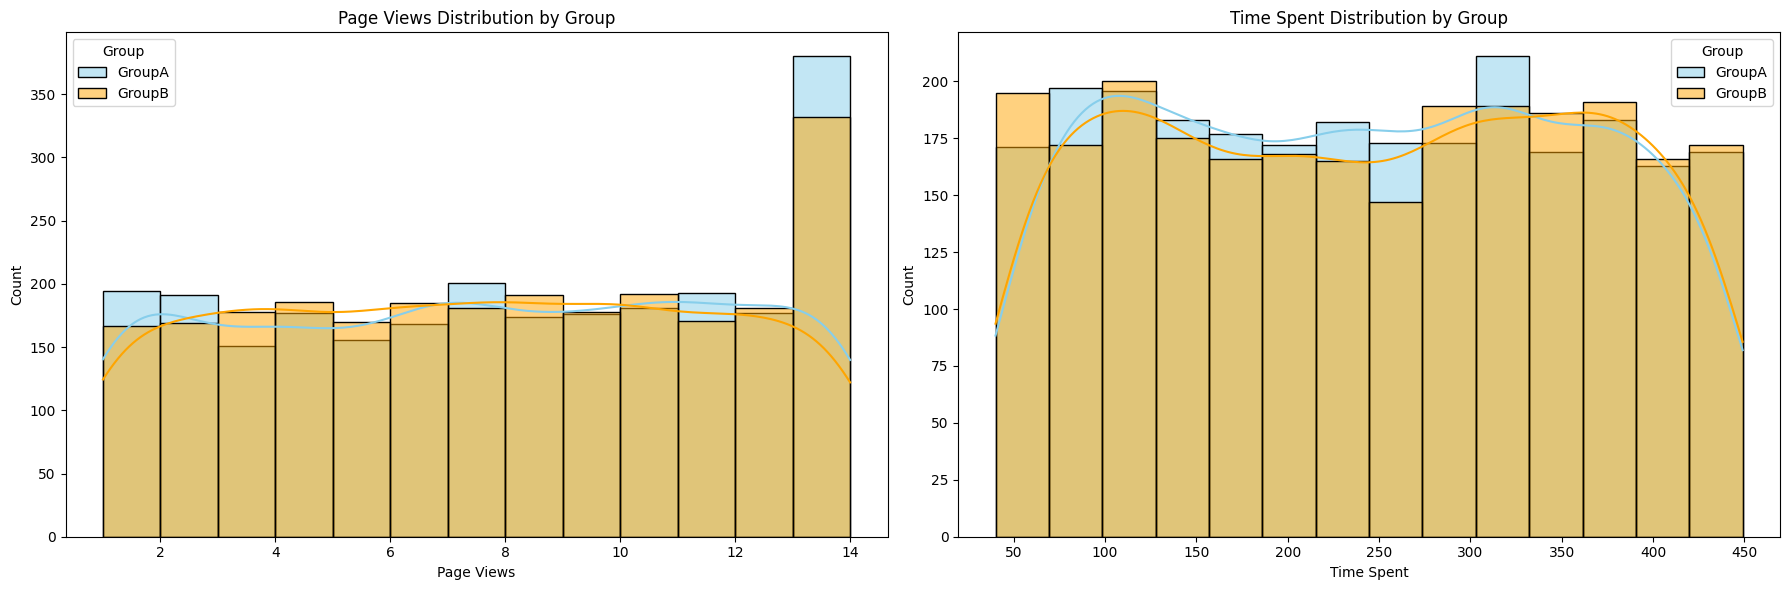

In [29]:
# **数据可视化**：
# A/B组页面浏览量和逗留时间分布
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(data=ab_data[ab_data['Group'] == 'A'], x='Page Views', kde=True, label='GroupA', color='skyblue', ax=axes[0])
sns.histplot(data=ab_data[ab_data['Group'] == 'B'], x='Page Views', kde=True, label='GroupB', color='orange', ax=axes[0])
axes[0].set_title('Page Views Distribution by Group')
axes[0].legend(title='Group') 

sns.histplot(data=ab_data[ab_data['Group'] == 'A'], x='Time Spent', kde=True, label='GroupA', color='skyblue', ax=axes[1])
sns.histplot(data=ab_data[ab_data['Group'] == 'B'], x='Time Spent', kde=True, label='GroupB', color='orange', ax=axes[1])
axes[1].set_title('Time Spent Distribution by Group')
axes[1].legend(title='Group')

plt.tight_layout()
plt.show()

上图我们绘制出了AB组的人数随页面浏览量和逗留时间变化的相关关系，从中可以得到以下结论：

- 从总体上来看，A，B组用户的浏览行为相差不大。

- 高页面浏览量的用户数显著多于其他页面浏览量的用户数(这可能是由于该网页拥有较多的活跃用户)

- 逗留时间大致呈双峰分布，但总体仍较为均匀

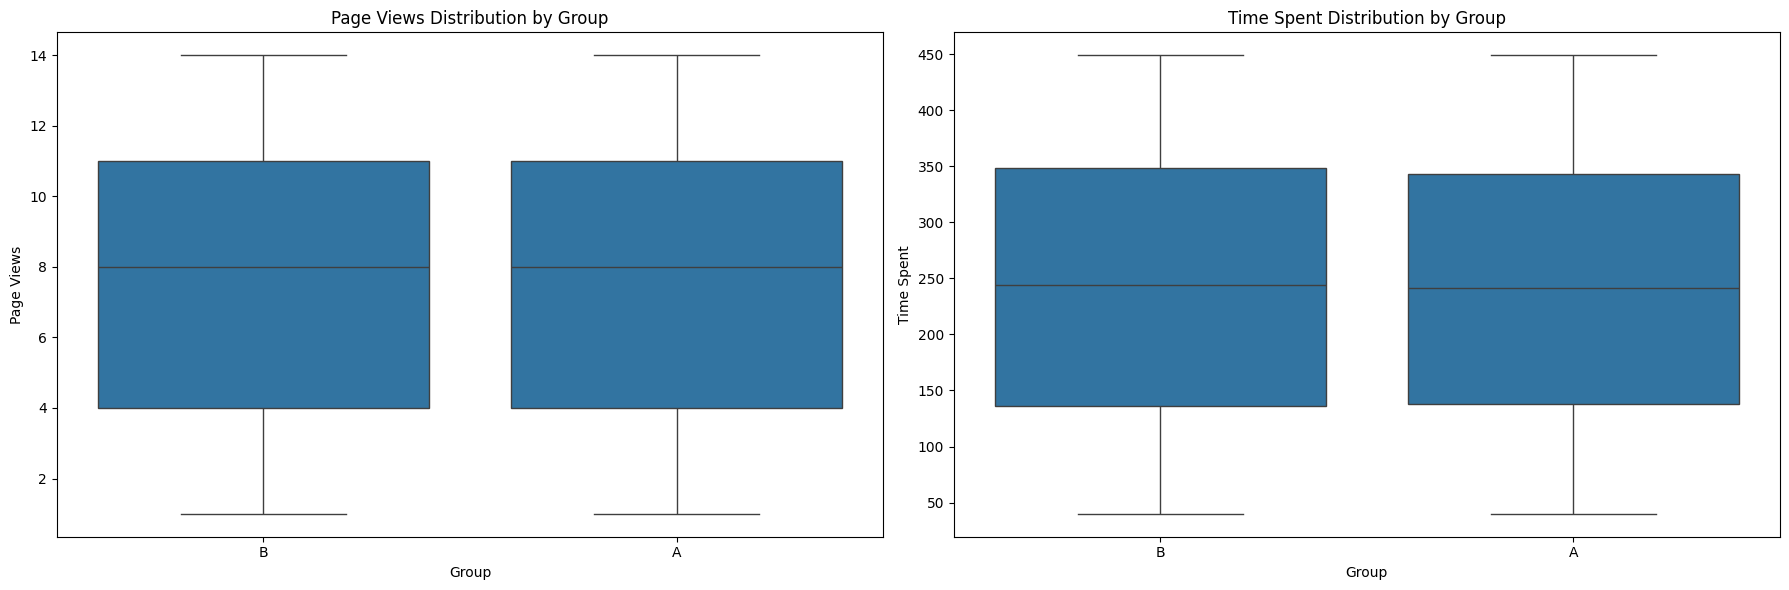

In [30]:
# 箱线图：展示A组和B组的页面浏览量和逗留时间分布
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(x='Group', y='Page Views', data=ab_data, ax=axes[0])
axes[0].set_title('Page Views Distribution by Group')

sns.boxplot(x='Group', y='Time Spent', data=ab_data, ax=axes[1])
axes[1].set_title('Time Spent Distribution by Group')

plt.tight_layout()

上面的箱线图再次验证了总体上A，B组用户的浏览行为差异不大，即更换网页背景颜色可能并不能对用户总体的浏览时长和浏览页面数产生显著影响。当然，我们还需要对此进行假设及验证。

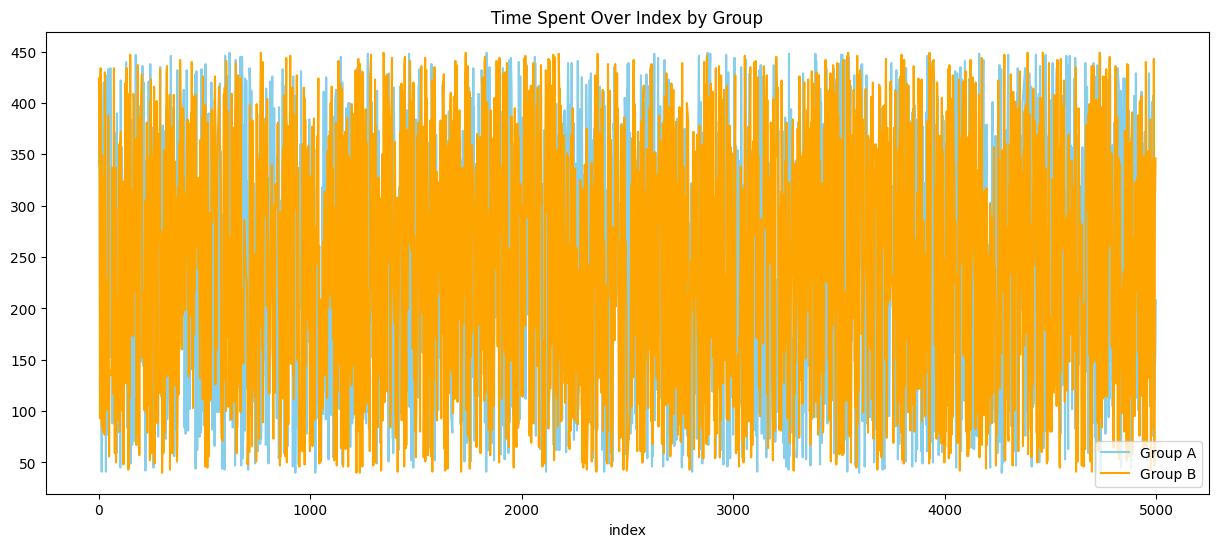

In [31]:
# 序列图：展示A组和B组的逗留时间的变化
plt.figure(figsize=(15, 6))
ab_data[ab_data['Group'] == 'A'].reset_index().set_index("index")['Time Spent'].plot(label="Group A", color='skyblue')
ab_data[ab_data['Group'] == 'B'].reset_index().set_index("index")['Time Spent'].plot(label="Group B", color='orange')
plt.title('Time Spent Over Index by Group')
plt.legend()
plt.show()

从上面的图像可以看出，A，B组总体的用户浏览行为并没有很大的差别，然而就用户个体而言，其浏览行为差异是很大的，有的用户可能浏览页面较少，但在每个页面上花费了很多时间；有的用户浏览页面多，但每个页面只停留几秒，因此，单纯的对用户的浏览页面和逗留时间分别进行检验可能并不能有效的模拟用户的实际行为，我们可以进一步考虑使用每个用户的页平均浏览时间作为新的指标进行研究，作为对比，我仍会将使用页面浏览数和逗留时间二维指标的实验进行到底。

新指标定义为：

$$页平均浏览时间 = \frac{逗留时间}{页面浏览数}$$

# 4.**应用假设检验并检验假设**

下面，我们将利用已处理过的数据，对选取的两组指标分别进行假设检验。

这里，不妨记以*页浏览量*和*逗留时间*为二维指标的实验为**实验一**，以*页平均浏览时间*为指标的实验为**实验二**。

假设检验步骤：

1.检验正态性

2.根据正态性结果选择检验方法检验方差齐性

3.根据正态性结果和方差齐性结果选择检验方法得到最终检验结果

## **实验一**

### **制定假设**：

- **原假设($H_0$)**:两组的页面浏览量和逗留时间没有显著差异（即实验组和对照组的均值相等）

- **备择假设($H_1$)**:实验组和对照组的页面浏览量或逗留时间存在显著差异。

### **检查正态性和方差齐性**

#### **检查正态性**

常用的正态性检验方法有 Shapiro-Wilk 检验、Kolmogorov-Smirnov 检验等。Shapiro-Wilk 检验适用于样本量较小的数据，Kolmogorov-Smirnov 检验适用于大样本。这里我们使用Shapiro-Wilk检验方法对数据的正态性进行检验。

In [33]:
from scipy import stats

# 正态性检验函数
def normality_test(data, column):
    stat, p_value = stats.shapiro(data[column])
    print(f"Shapiro-Wilk test for {column}:")
    print(f"Statistic: {stat}, p-value: {p_value}")
    
    # 判断是否符合正态分布
    if p_value > 0.05:
        print(f"{column} follows a normal distribution.")
    else:
        print(f"{column} does not follow a normal distribution.")

# 对照组与实验组进行正态性检验
print("Testing normality for 'Page Views' and 'Time Spent' columns:")
normality_test(ab_data[ab_data['Group'] == 'A'], 'Page Views')
normality_test(ab_data[ab_data['Group'] == 'A'], 'Time Spent')

normality_test(ab_data[ab_data['Group'] == 'B'], 'Page Views')
normality_test(ab_data[ab_data['Group'] == 'B'], 'Time Spent')


Testing normality for 'Page Views' and 'Time Spent' columns:
Shapiro-Wilk test for Page Views:
Statistic: 0.9418101396339102, p-value: 2.1371807816693293e-30
Page Views does not follow a normal distribution.
Shapiro-Wilk test for Time Spent:
Statistic: 0.9548671064698608, p-value: 3.083246433138437e-27
Time Spent does not follow a normal distribution.
Shapiro-Wilk test for Page Views:
Statistic: 0.9481565533306111, p-value: 9.739883236584908e-29
Page Views does not follow a normal distribution.
Shapiro-Wilk test for Time Spent:
Statistic: 0.9514252794431708, p-value: 6.1796874034872095e-28
Time Spent does not follow a normal distribution.


从上述检验结果可以看到，AB组页面浏览量和逗留时间均不符合正态分布。

#### **检查方差齐性 (同质性)**

如果数据服从正态分布（即参数检验），则进一步进行Levene检验，检查两组数据的方差是否齐性。

如果数据服从正态分布且方差齐性（满足t检验假设），则使用t检验来比较两组的均值差异。

如果数据服从正态分布，但方差不齐（不满足t检验假设），则使用Welch检验，它是对t检验的一种改进，适用于方差不齐的情况。

如果数据不服从正态分布（非参数检验），则直接使用Mann-Whitney U检验进行组间差异比较。

由上述结果，数据不服从正态分布，无需进行方差齐性检验。

下面我们对假设进行非参数检验，直接使用Mann-Whitney U检验进行组间差异比较。

In [34]:
from scipy import stats

# Mann-Whitney U检验
def mann_whitney_u_test(group1, group2, column):
    stat, p_value = stats.mannwhitneyu(group1[column], group2[column])
    print(f"Mann-Whitney U Test for {column}:")
    print(f"Statistic: {stat}, p-value: {p_value}")
    
    if p_value > 0.05:
        print(f"No significant difference in {column}.")
    else:
        print(f"Significant difference in {column}.")

# 对照组与实验组进行Mann-Whitney U检验
mann_whitney_u_test(ab_data[ab_data['Group'] == 'A'], ab_data[ab_data['Group'] == 'B'], 'Page Views')
mann_whitney_u_test(ab_data[ab_data['Group'] == 'A'], ab_data[ab_data['Group'] == 'B'], 'Time Spent')


Mann-Whitney U Test for Page Views:
Statistic: 3165458.0, p-value: 0.42467839841511335
No significant difference in Page Views.
Mann-Whitney U Test for Time Spent:
Statistic: 3101095.0, p-value: 0.6420301034033706
No significant difference in Time Spent.


可以看到，最终计算得到的结果是无法拒绝原假设，因此两组的页面浏览量和逗留时间没有显著差异（即实验组和对照组的均值相等）。

## **实验二**

### **制定假设**：

- **原假设($H_0$)**:两组的页面浏览量和逗留时间没有显著差异（即实验组和对照组的均值相等）

- **备择假设($H_1$)**:实验组和对照组的页面浏览量或逗留时间存在显著差异。

### **计算页平均逗留时间**

首先将该指标计算出来并打印在代码块下进行查看。

In [43]:
# 计算平均逗留时间
ab_data['Avg Time Spent'] = ab_data['Time Spent'] / ab_data['Page Views']

# 查看新的数据集，确认计算结果
print(ab_data[['User ID', 'Group', 'Conversion', 'Page Views', 'Time Spent', 'Avg Time Spent']].head())

   User ID Group  Conversion  Page Views  Time Spent  Avg Time Spent
0    14292     B         NaN           3         424        141.3333
1    11682     A         NaN           9         342         38.0000
2    19825     A         NaN           2         396        198.0000
3    16080     B         NaN           4         318         79.5000
4    18851     A         NaN           1         338        338.0000


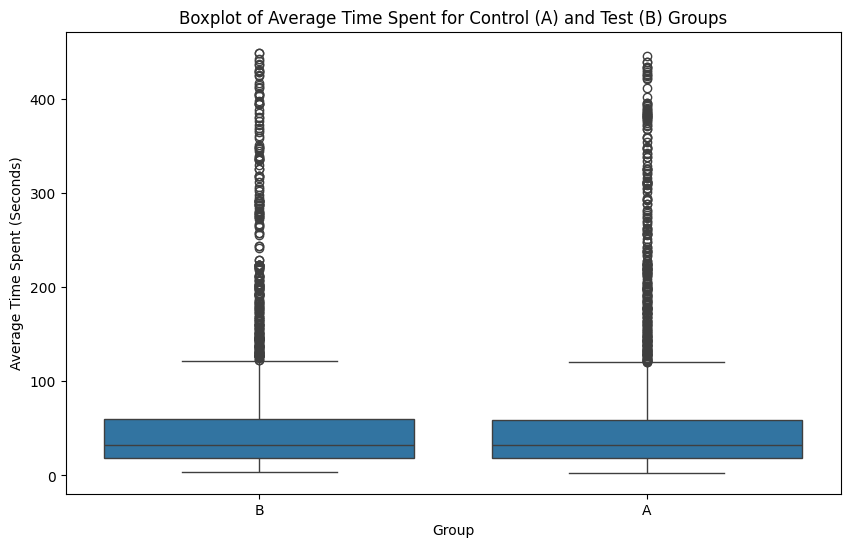

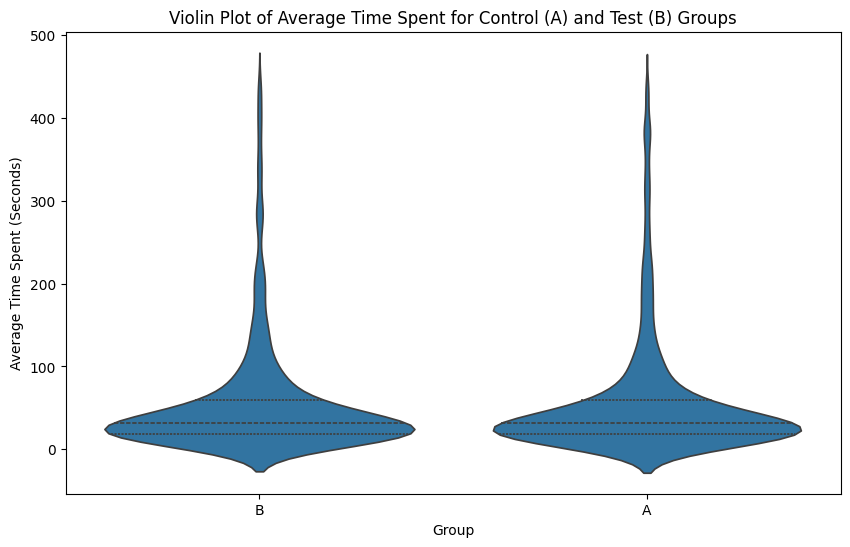

In [36]:
# 导入绘图包
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制箱线图，比较两组的平均逗留时间
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Avg Time Spent', data=ab_data)
plt.title('Boxplot of Average Time Spent for Control (A) and Test (B) Groups')
plt.xlabel('Group')
plt.ylabel('Average Time Spent (Seconds)')
plt.show()

# 绘制小提琴图，进一步展示两组的分布情况
plt.figure(figsize=(10, 6))
sns.violinplot(x='Group', y='Avg Time Spent', data=ab_data, inner="quart")
plt.title('Violin Plot of Average Time Spent for Control (A) and Test (B) Groups')
plt.xlabel('Group')
plt.ylabel('Average Time Spent (Seconds)')
plt.show()


从上图可以看出，两组的页平均逗留时间仍然没有太大差异。

### **检查正态性和方差齐性**

#### **检查正态性**

仍然使用 Shapiro-Wilk 检验进行检验。

In [37]:
# 对照组与实验组进行正态性检验
normality_test(ab_data[ab_data['Group'] == 'A'], 'Avg Time Spent')
normality_test(ab_data[ab_data['Group'] == 'B'], 'Avg Time Spent')

Shapiro-Wilk test for Avg Time Spent:
Statistic: 0.6236732390874804, p-value: 3.157488719988072e-59
Avg Time Spent does not follow a normal distribution.
Shapiro-Wilk test for Avg Time Spent:
Statistic: 0.6305559185985412, p-value: 1.3865356252959309e-58
Avg Time Spent does not follow a normal distribution.


从上可以看出，页平均逗留时间依旧不满足正态分布。因此，我们直接对原假设进行检验，同理，使用Mann-Whitney U检验。

In [39]:
from scipy.stats import mannwhitneyu

# 对照组与实验组的平均逗留时间进行Mann-Whitney U检验
group_A = ab_data[ab_data['Group'] == 'A']['Avg Time Spent']
group_B = ab_data[ab_data['Group'] == 'B']['Avg Time Spent']

# Mann-Whitney U检验
stat, p_value = mannwhitneyu(group_A, group_B, alternative='two-sided')

print(f"Mann-Whitney U test statistic: {stat}, p-value: {p_value}")

# 根据p值判断是否拒绝原假设
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the groups.")

Mann-Whitney U test statistic: 3109665.5, p-value: 0.7665231868778632
Fail to reject the null hypothesis: There is no significant difference between the groups.


可以看到，最终计算得到的结果是无法拒绝原假设，因此两组的页面浏览量和逗留时间没有显著差异（即实验组和对照组的均值相等）。

# 5.检验假设效应大小

由于经检验，两组的实验结果无显著性差异，故无需进行效应大小检验。

# 6.报告与决策

通过ab测试，我们发现将网页的白色背景更改为黑色背景并不能显著提升用户的参与度，因此可以不对该计划进行实施。

导致该结果的可能原因有：

- 背景颜色的改变可能对用户参与度的影响不如预期。如果用户对页面颜色的敏感度较低，可能背景颜色的变化不会引起明显的行为改变，导致两组的平均逗留时间没有显著差异。

- 样本量较小，可能导致测试的统计功效不够，无法捕捉到真正的差异。

- 用户的设备（手机、平板、电脑）以及地域差异可能对他们的参与度产生影响。如果这些因素没有在实验设计中进行控制，可能会对实验结果产生干扰。

- 背景颜色的变化可能只是页面设计的一部分，用户体验的提升往往取决于多个因素的结合，比如布局、文字、图片等。单独改变背景颜色，可能无法产生足够显著的效果。

- 如果实验运行时间过短，可能没有足够的时间来观察背景颜色变化对用户行为的影响。增加实验的时长或延长观察期，可能会得到更可靠的结果。

# 7.**其他尝试**

在上面的ab测试中，我们仅考虑对用户的参与度进行测试，即不考虑用户是否完成购买、注册等行为，但是在实际应用中，公司往往更关注用户是否完成购买等行为，而不是用户浏览页面的时间长短。因此，我们可以以提升公司经营价值为目标，即检查**如果将网页的白色背景更改为黑色背景，会不会影响用户的购买、注册率**。同上步骤，我们选取用户是否完成相关操作的转化为指标，进行新的ab测试。

ab测试的具体步骤如上，不再赘述。

## **数据转化与处理**

由于表中的转化指标为字符串类型，我们可以考虑将其转换为数值型/bool型，以便后续定量讨论。

In [62]:
# 将转换列转换为布尔类型：'Yes' -> 1, 'No' -> 0
ab_data['Conversion'] = ab_data['Conversion'].map({'Yes': 1, 'No': 0})

# 计算A组和B组的转化率
conversion_A = ab_data[ab_data['Group'] == 'A']['Conversion'].mean()
conversion_B = ab_data[ab_data['Group'] == 'B']['Conversion'].mean()

# 输出转化率
print(f"Conversion rate for Group A: {conversion_A:.4f}")
print(f"Conversion rate for Group B: {conversion_B:.4f}")


Conversion rate for Group A: 0.0540
Conversion rate for Group B: 0.1407


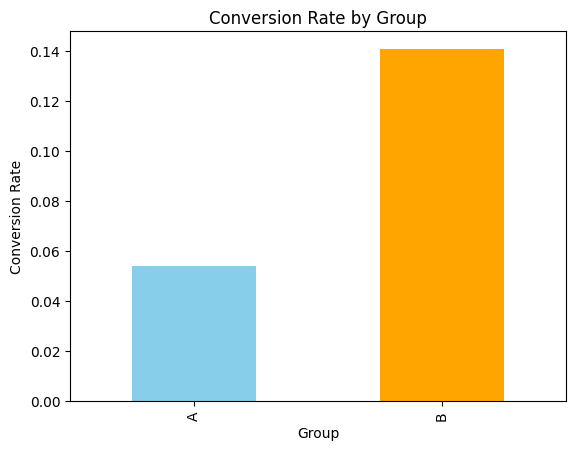

In [63]:
# 转化率对比：使用条形图展示A组和B组的转化率差异
conversion_rate = ab_data.groupby("Group")['Conversion'].mean()
conversion_rate.plot(kind='bar', color=['skyblue', 'orange'], title='Conversion Rate by Group')
plt.ylabel('Conversion Rate')
plt.show()

从上述图像展示结果可以看出，AB组的转化率存在较大差异。

## AA测试

AA测试（A/A Test）是指将两个相同的实验组（Group A 和 Group A）进行比较的实验设计。这个实验的主要目的是在测试中消除系统性误差，并验证实验设计和数据收集过程的正确性。AA测试并不涉及任何实际的干预或变化，只是用于确认在没有实际变化的情况下，实验方法能否正确地分配用户并且给出合理的结果。

理论上，我们应该在实验前进行空跑，消除测试中的系统性误差，但在本次实验提供的数据集中没有实验开始前的AB组原始数据，因此我们这里在A组中随机抽取用户进行AA测试，注意，这并不是本实验的AA测试，而是将分桶到A组的流量再次分流，对从A组分流出来的流量进行AA测试。下面的AA测试与本实验无关，仅用于展示AA测试的步骤。

In [50]:
# 假设ab_data是你的实验数据框，包含两个A组
# 1. 随机将用户分配到两个组
ab_data['Group'] = np.random.choice(['A1', 'A2'], size=len(ab_data))

# 2. 设置实验指标：转化率、页面浏览量、停留时间
# 假设转换为0和1，表示是否转化
ab_data['Conversion'] = np.random.choice([0, 1], size=len(ab_data), p=[0.8, 0.2])

# 3. 统计A/A组的转化率差异
from scipy.stats import ttest_ind

# 计算每个组的转化率
conversion_A1 = ab_data[ab_data['Group'] == 'A1']['Conversion']
conversion_A2 = ab_data[ab_data['Group'] == 'A2']['Conversion']

# t检验：A组与A组之间的差异
t_stat, p_value = ttest_ind(conversion_A1, conversion_A2)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

# 4. 检查统计结果
if p_value > 0.05:
    print("A/A Test Passed: No significant difference.")
else:
    print("A/A Test Failed: Significant difference detected.")


t-statistic: 0.39471873697404747, p-value: 0.6930673158577236
A/A Test Passed: No significant difference.


可以看到AA测试结果显示无显著性差异，即数据收集合理。

## **假设检验**

- **原假设($H_0$)**:两组的转化数没有显著差异（即实验组和对照组的均值相等）

- **备择假设($H_1$)**:实验组和对照组的转换数存在显著差异。

检验方法： 对于二元离散数据，常用的假设检验方法包括：

- 卡方检验（Chi-square test）：适用于比较两组数据的频数分布是否有显著差异。

- Fisher精确检验：当样本量较小或频数较低时，Fisher精确检验更为合适。

这里我们使用卡方检验。

In [64]:
from scipy.stats import chi2_contingency

# 构建列联表
contingency_table = pd.crosstab(ab_data['Group'], ab_data['Conversion'])

# 卡方检验
chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)

# 输出结果
print(f"Chi-square statistic: {chi2_stat}, p-value: {p_val}")

if p_val < 0.05:
    print("Reject H0: There is a significant difference between groups.")
else:
    print("Fail to reject H0: No significant difference between groups.")


Chi-square statistic: 106.22812337440538, p-value: 6.571736018334222e-25
Reject H0: There is a significant difference between groups.


除了以上的假设检验方法，我们还可以使用Bootstrap 方法 来计算置信区间，从而判断显著性差异。Bootstrap 方法是一种重采样技术，用于估计统计量（如均值、方差等）的分布，不依赖于数据的分布假设。

In [68]:
import numpy as np

# 设置bootstrap样本数量
n_iterations = 10000
bootstrap_A = []
bootstrap_B = []

for _ in range(n_iterations):
    sample_A = ab_data[ab_data['Group'] == 'A'].sample(frac=1, replace=True)
    sample_B = ab_data[ab_data['Group'] == 'B'].sample(frac=1, replace=True)
    
    bootstrap_A.append(sample_A['Conversion'].mean())
    bootstrap_B.append(sample_B['Conversion'].mean())

# 计算置信区间
ci_A = np.percentile(bootstrap_A, [2.5, 97.5])
ci_B = np.percentile(bootstrap_B, [2.5, 97.5])

print(f"Bootstrap 95% CI for Group A: {ci_A}")
print(f"Bootstrap 95% CI for Group B: {ci_B}")


Bootstrap 95% CI for Group A: [0.04525605 0.06312029]
Bootstrap 95% CI for Group B: [0.127368   0.15397017]


Bootstrap 95% Confidence Interval for the Difference in Conversion Rates: [-0.10274737 -0.0705812 ]


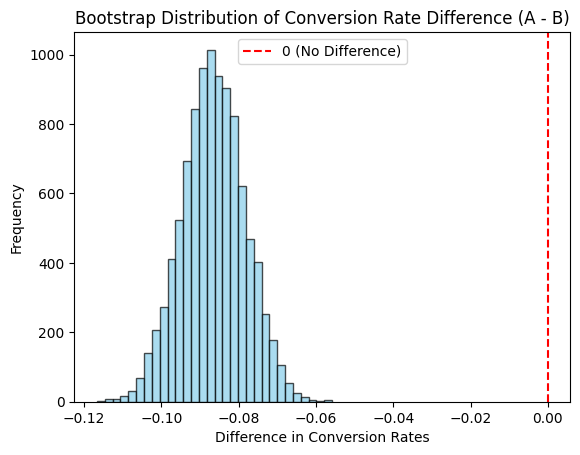

In [69]:
# 计算 A组和B组之间的转化率差异
bootstrap_diff = np.array(bootstrap_A) - np.array(bootstrap_B)

# 计算差异的置信区间
ci_diff = np.percentile(bootstrap_diff, [2.5, 97.5])
print(f"Bootstrap 95% Confidence Interval for the Difference in Conversion Rates: {ci_diff}")

# 绘制转化率差异的直方图
plt.hist(bootstrap_diff, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(x=0, color="red", linestyle="--", label="0 (No Difference)")
plt.title("Bootstrap Distribution of Conversion Rate Difference (A - B)")
plt.xlabel("Difference in Conversion Rates")
plt.ylabel("Frequency")
plt.legend()
plt.show()


结论

转化率差异的置信区间：从图表可以看出，转化率差异的分布明显偏向负值，表示 A 组的转化率显著低于 B 组。差异的 大部分样本 都落在 -0.12 到 0 之间，且 0（没有差异）的位置远离该分布。
由于大部分 Bootstrap 样本 显示 A组的转化率低于B组，且 置信区间不包含零，这表明 A组和B组之间存在显著的转化率差异，且 B组的转化率较高。

如何解释结论

拒绝零假设：由于转化率差异的 置信区间 不包含 0，我们可以 拒绝零假设，即认为 A组和B组之间的转化率存在显著差异。

实验结果：实验结果显示，B组的转化率显著高于A组，这表明实验组的背景颜色（或其他因素）在提升转化率方面起到了积极作用。

综上，结果显示拒绝原假设，即实验组和对照组的转换数存在显著差异。(如果运行结果与预期不符，请重新导入数据，因为上面的模拟AA测试会改变分组,请不要运行AA测试的代码)

## **验证假设效应大小**

对于t检验（对于连续数据）和卡方检验（对于分类数据）等方法，我们通常计算 Cohen's d 或 卡方效应大小来验证假设效应的大小。

### 1. **Cohen's d**（适用于t检验）：  
Cohen's d 是用来衡量两个组的均值差异的效应大小。它的计算公式为：
$$
d = \frac{\mu_1 - \mu_2}{\sigma_p}
$$
其中：
- $ \mu_1, \mu_2 $ 分别是两个组的均值
- $ \sigma_p $ 是两组的合并标准差

Cohen's d的解释标准：
- $ d < 0.2 $: 小效应
- $ 0.2 \leq d < 0.5 $: 中效应
- $ d \geq 0.5 $: 大效应

### 2. **Cramér's V**（适用于卡方检验）：  
如果使用卡方检验来验证二元离散数据（比如转化率），可以计算 **Cramér's V** 作为效应大小指标。Cramér's V 的计算公式为：
$$
V = \sqrt{\frac{\chi^2}{n \cdot \min(k - 1, r - 1)}}
$$
其中：
- $\chi^2 $ 是卡方统计量
- $ n $ 是样本总数
- $ k  $是分类变量的类别数
- $ r $ 是另一个分类变量的类别数

Cramér's V 的解释：
- $V < 0.1 $: 小效应
- $0.1 \leq V < 0.3 $: 中效应
- $ V \geq 0.3 $: 大效应


### 3. **分析效应大小**：

- **Cohen's d** 和 **Cramér's V** 都能量化实验组和对照组之间的差异大小。即使结果显著，效应大小可以帮助我们评估这种差异的实际影响。

- 如果效应大小很小，即使 p 值显著，也可能意味着这种差异并不具有实际意义，因此效应大小的分析很重要。

In [67]:
import scipy.stats as stats
from math import sqrt
# 创建2x2列联表
contingency_table = pd.crosstab(ab_data['Group'], ab_data['Conversion'])

# 卡方检验
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# 计算Cramér's V
n = contingency_table.sum().sum()  # 总样本数
min_dim = min(contingency_table.shape) - 1  # 最小维度数减去1
cramers_v = sqrt(chi2 / (n * min_dim))

print(f"Cramér's V: {cramers_v:.4f}")


Cramér's V: 0.1458


Cramér's V 值为 0.1458，根据解释标准，它属于 小效应（一般来说，小效应在 0.1 到 0.3 之间）。这意味着尽管在 AB 测试中获得了显著的统计差异（通过 p 值），但这种差异的实际影响比较小。换句话说，实验组和对照组之间的转化率差异在实际应用中的意义并不大。

## **报告与决策**

根据实验结果，我们发现背景颜色的改变对用户的转化率产生了显著影响。尽管差异不极为显著（中等效应），但可以合理推测，改变网站背景颜色可能对提升转化率具有一定的潜力。因此，建议在后续的实验和实际应用中考虑实施这种背景颜色的改动。

然而，考虑到差异的效应大小属于中等，建议在进一步的实验中优化其他元素（如按钮颜色、布局设计等），以进一步提升用户体验和转化率。

下一步建议
- 长期实验验证：实施黑色背景在更多的页面上，并进行长期监测，以确认实验结果的长期有效性。
- 多变量测试：除了背景颜色，可以测试其他设计元素（如字体、按钮位置等）对转化率的影响，以获得更全面的优化方案。
- 用户反馈调查：结合用户反馈，进一步理解用户对网站视觉元素的偏好，优化用户体验。

### 总结：
- **转化率** 与 **页面停留时间** 和 **页面查看次数** 可能具有不同的关联性和影响因素。在 A/B 测试中，转化率作为最终的目标变量，往往受到 **设计、内容、用户体验** 和 **行为动机** 的综合影响，而不仅仅是参与度指标。
- 尽管 **B组** 可能在 **页面停留时间** 或 **页面查看次数** 上表现较好，但这并不一定意味着 **转化率** 会有显著提升。
- 需要结合多方面因素综合分析，进一步探索影响 **转化率** 的其他潜在因素，可能包括 **页面设计细节**、**用户体验**、**促销策略** 等。


# **附录**


## 1.**缺失值处理**

处理数据中的缺失值是数据预处理中的重要步骤，不恰当的缺失值处理可能会影响分析结果，甚至导致偏差。因此，选择合适的缺失值处理方法非常关键。值得庆幸的是，本数据集中没有出现缺失值，如果在数据集中出现缺失值，可以通过以下几种常见的方法处理缺失值：

### 1. **删除缺失值**

#### a. **删除包含缺失值的行（完全删除）**
如果缺失值的比例较小，可以选择 **删除含有缺失值的行**。这种方法的优点是简单且快速，但缺点是可能丢失部分重要的数据，尤其是在缺失值较多时。

- **适用场景**：当数据集中缺失值的比例很小，且删除这些数据对整体分析影响较小。
- **注意**：如果缺失值不随机（例如某些变量缺失集中在某些类别），可能会引入偏差。

#### b. **删除某些变量（特征）**
如果某个特征的缺失值非常多，可以考虑删除该特征。特别是对于某些特征，缺失值太多可能导致这个特征对分析的贡献变小，甚至无法有效分析。

- **适用场景**：当某个特征的缺失值比例较高，且删除该特征不会影响分析的关键结论。

### 2. **填充缺失值**

填充缺失值的常见方法包括：

#### a. **使用均值/中位数/众数填充（适用于数值型数据）**
- **均值填充**：对数值型变量，使用该变量的 **均值** 填充缺失值。
- **中位数填充**：当数据分布较为偏斜时，使用 **中位数** 代替均值，避免极端值影响结果。
- **众数填充**：对于分类变量，使用 **众数**（出现频率最高的值）填充缺失值。

**优缺点**：
- **优点**：简单、易操作，特别适用于数据缺失较少时。
- **缺点**：均值填充可能掩盖数据的真实分布，可能降低数据的变异性，从而影响模型性能。

#### b. **使用前后值填充（适用于时间序列数据）**
在时间序列数据中，可以使用前一个值（**前向填充**）或后一个值（**后向填充**）来填充缺失值。此方法利用时间序列的连续性。

- **适用场景**：时间序列数据，如股票价格、气温等。
- **优点**：能较好地保留数据的趋势和周期性。
- **缺点**：在一些数据中，如果连续性较弱，可能会引入误差。

#### c. **线性插值法（适用于数值型数据）**
线性插值通过连接缺失值前后的数据点来填充缺失值，适合于数据点之间存在线性关系时。

- **适用场景**：适用于数值型数据，且数据变化趋势较为平稳。
- **优点**：能够较为准确地填补缺失数据，特别是在数据变化平滑的情况下。
- **缺点**：如果数据波动较大，插值可能不够准确。

#### d. **回归填充（基于其他变量预测缺失值）**
回归填充是利用已有数据中的特征预测缺失值。例如，可以使用 **线性回归**、**决策树回归** 等模型来预测缺失值。这种方法基于其他变量来预测缺失值。

- **适用场景**：当缺失值较多时，且缺失的变量与其他特征有较强的关联。
- **优点**：能利用其他信息较为准确地预测缺失值。
- **缺点**：需要构建回归模型，且对数据的要求较高。可能引入偏差，尤其是当其他特征与缺失值关联不强时。

#### e. **K近邻填充（KNN）**
KNN填充通过寻找数据集中与缺失值相似的k个邻居，然后基于这些邻居的值来填充缺失值。对于分类变量，可以使用多数投票法填充，对于数值变量，则使用平均值或加权平均值。

- **适用场景**：适用于数据中有一定的相似性，且希望通过近邻的信息来填补缺失值。
- **优点**：考虑到多个变量之间的关系，较为准确。
- **缺点**：计算量较大，尤其是在样本量较大的情况下。

### 3. **使用模型填充（多重插补）**

#### a. **多重插补（Multiple Imputation）**
多重插补是一种更为复杂且准确的填充方法。它通过多次使用回归模型（如逻辑回归、线性回归等）来估计缺失值，并生成多个填充数据集。这种方法有助于减少由于单一估算带来的不确定性。

- **适用场景**：适用于缺失值比例较高，且缺失数据可能依赖于其他变量的场景。
- **优点**：可以提供填充的不确定性度量，增加填充的鲁棒性。
- **缺点**：计算较为复杂，处理时间较长。

### 4. **利用数据增强**

#### a. **数据增强（Data Augmentation）**
数据增强通常用于深度学习中，尤其是图像处理和文本处理中。可以通过各种方法（如旋转、缩放、噪声添加等）生成新的训练数据。在缺失数据处理中，某些情况下可以通过类似方法生成新的样本来代替缺失值。

- **适用场景**：主要适用于图像、文本等领域。
- **优点**：能够生成多样的样本，增强模型的鲁棒性。
- **缺点**：不适用于传统的表格数据，且生成的增强数据可能不真实。

### 5. **保留缺失值**

#### a. **保留缺失值作为一个类别**
对于分类变量的缺失值，可以将缺失值当作一个特殊的类别（例如，"未知"、"无"、"缺失"）。这种方法适用于缺失值本身具有一定信息的场景。

- **适用场景**：分类变量（例如，性别、地区等）中缺失值具有特殊含义，或缺失本身可能对结果有影响。
- **优点**：不需要对数据进行插补，保持数据原始状态。
- **缺点**：可能引入噪音，尤其是缺失值与其他类别数据没有明显关系时。

### 6. **决定策略依据**

选择适当的缺失值处理方法时，需要根据以下因素决定：
- **缺失值的类型**：是完全随机缺失（MCAR），还是随机缺失（MAR），还是非随机缺失（MNAR）？
- **缺失值的比例**：如果缺失值较少（如低于5%），可以考虑删除或简单填充；如果缺失值较多，可能需要使用更复杂的填充方法。
- **变量类型**：数值型变量、分类变量、时间序列数据等的处理方法有所不同。
- **对模型的影响**：缺失值处理不当可能导致模型偏差，甚至影响预测准确度，因此要权衡填补方法的复杂性与模型表现。

## 2.**样本量计算**

在A/B测试中，确定合适的样本量对于确保测试结果的可靠性和统计显著性至关重要。以下是确定样本量的关键步骤和方法：

### 1. 确定关键参数

- **显著性水平（α）**：通常设定为0.05，表示有5%的概率犯下第一类错误（即错误地拒绝原假设）。

- **统计功效（1-β）**：通常设定为0.8或0.9，表示有80%或90%的概率正确地拒绝原假设。

- **最小可检测效果（Δ）**：即希望检测到的最小差异。例如，当前转化率为5%，希望检测到提升至6%的变化，则Δ为1%。

- **数据的标准差（σ）**：衡量数据的波动性，可通过历史数据估计。

### 2. 样本量计算公式

对于比较两组比例（如转化率）的情况，样本量计算公式如下：

$$ n = \frac{{2 \times (Z_{\alpha/2} + Z_{\beta})^2 \times \sigma^2}}{{\Delta^2}} $$

其中：

- $ n $：每组所需的样本量。

- $ Z_{\alpha/2} $：标准正态分布中对应显著性水平的一侧临界值。例如，α=0.05时，$ Z_{\alpha/2} \approx 1.96 $

- $Z_{\beta} $：对应统计功效的临界值。例如，β=0.2时，$ Z_{\beta} \approx 0.84 $。

- $ \sigma $：数据的标准差。

- $ \Delta $：最小可检测效果。

需要注意的是，以上公式适用于大样本情况下的近似计算。对于小样本或数据不满足正态分布时，可能需要采用其他统计方法。

### 3. 实际计算示例

假设：

- 当前转化率（p）为5%（即0.05）。

- 希望检测到的提升为1%（即Δ=0.01）。

- 显著性水平α=0.05，对应的$ Z_{\alpha/2} \approx 1.96 $。

- 统计功效1-β=0.8，对应的$ Z_{\beta} \approx 0.84 $。

由于是比例数据，标准差σ可以表示为：

$$\sigma = \sqrt{p \times (1 - p)} = \sqrt{0.05 \times (1 - 0.05)} \approx 0.218 $$

将这些值代入公式：

$$n = \frac{{2 \times (1.96 + 0.84)^2 \times 0.218^2}}{{0.01^2}} \approx 34520 $$

因此，每组需要约34,520个样本，总共约69,040个样本。

### 4. 在线计算工具

为了简化计算过程，可以使用在线样本量计算器。例如，Evan Miller的网站提供了直观的A/B测试样本量计算工具：

[https://www.evanmiller.org/ab-testing/sample-size.html](https://www.evanmiller.org/ab-testing/sample-size.html)

在该工具中输入基线转化率、最小可检测效果、显著性水平和统计功效，即可快速获得所需的样本量。

### 5. 注意事项

- **平衡业务成本**：样本量越大，测试结果越可靠，但同时也意味着更高的时间和资源成本。需要在统计精度和业务成本之间找到平衡。

- **持续监测**：在测试过程中，持续监测数据，以确保在达到预定样本量前不会出现显著差异，避免提前终止导致的偏差。

- **考虑用户分层**：如果用户存在明显的分层（如新老用户、不同地区用户），应在样本量计算中考虑这些因素，确保各层级都有足够的样本量。

通过以上步骤和方法，您可以确定A/B测试所需的合理样本量，从而确保测试结果的可靠性和有效性。 

# 参考文献/链接

1.https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing

2.https://en.wikipedia.org/wiki/A/B_testing#Common_test_statistics

3.https://www.udacity.com/enrollment/ud257

4.https://zhuanlan.zhihu.com/p/68019926